# UE Computer Vision | Project : Visual tracking of video objects

pierre-henri.conze@imt-atlantique.fr

# COLAB Preparation

The repo is modified (in several files) so that it can be run on any machine with NVIDIA GPU and Python 3.8 (not just on Colab)

Suprisingly, there are a github repo https://github.com/hmorimitsu/ptlflow that provides all state-of-the-art models and it is compatible with various range of Python version, no GPU restriction. The main advantage is that we do not need to change Python version on Colab, and crop the images before feeding into inference step, moreover, there is no GPU requirement. Thus, this can be run on our own machine.

We will introduce how to use it in the later of this part.

## Colab only

The following cells can work only on Colab to run the original Flownet 2 repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install python3.8 python3.8-distutils
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!apt-get install python3-pip
!python3 -m pip install --upgrade pip --user
!apt-get install python3.8-dev

## Requirements installation (Suppose having Python 3.8 and NVIDIA GPU)

In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorboardX
!pip install setproctitle
!pip install colorama
!pip install tdqm
!pip install scipy
!pip install scikit-image
!pip3 install -U PyCryptodome
!pip install matplotlib
!pip install pytz

Change the path to **flownet2-pytorch/networks/.** to build libraries of necessary functions

In [ ]:
%cd /content/drive/MyDrive/Project_CV/flownet2-pytorch/networks/channelnorm_package/

In [ ]:
!python3 setup.py build
!python3 setup.py install

In [6]:
%cd /content/drive/MyDrive/Project_CV/flownet2-pytorch/networks/correlation_package

/content/drive/MyDrive/Project_CV/flownet2-pytorch/networks/correlation_package


In [ ]:
!python3 setup.py build
!python3 setup.py install

In [8]:
%cd /content/drive/MyDrive/Project_CV/flownet2-pytorch/networks/resample2d_package

/content/drive/MyDrive/Project_CV/flownet2-pytorch/networks/resample2d_package


In [ ]:
!python3 setup.py build
!python3 setup.py install

In [10]:
%cd /content/drive/MyDrive/Project_CV/flownet2-pytorch/

/content/drive/MyDrive/Project_CV/flownet2-pytorch


Test network inference on 2 swan images:
- Specify the inference_dataset: **ImagesFromFolder**, other possible input: **MpiSintelClean, FlyingChairs,...**
- Indicate the path to your dataset directory in inference_dataset_root
- Using pretrained weights avalable on the github repo: *https://github.com/NVIDIA/flownet2-pytorch*
- Note that .bmp images have to be converted to .png before feeding into the model

Preprocess dataset

We need to crop the images before due to some upsampling scale problem

In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import os

def crop_dataset(path):
  crop_img_path = os.path.join(path, 'img_crop')
  crop_mask_path = os.path.join(path, 'mask_crop')
  try:
    os.mkdir(crop_img_path)
    os.mkdir(crop_mask_path)
  except:
    pass

  img_path = os.path.join(path, 'img')
  mask_path = os.path.join(path, 'mask')

  for img in os.listdir(img_path):
    if '.bmp' in img:
      img_to_crop = cv2.imread(os.path.join(img_path, img))
      name_img = img.split('.')[0]
      mask_to_crop = cv2.imread(os.path.join(mask_path, name_img + '.png'))
      h = img_to_crop.shape[0]
      w = img_to_crop.shape[1]
      if h%64 != 0:
        h = int(h/64)*64
      if w%64 != 0:
        w = int(w/64)*64
      mid_h = int(img_to_crop.shape[0]/2)
      mid_w = int(img_to_crop.shape[1]/2)
      img_to_crop = img_to_crop[mid_h-int(h/2):mid_h+int(h/2),mid_w-int(w/2):mid_w+int(w/2),:]
      mask_to_crop = mask_to_crop[mid_h-int(h/2):mid_h+int(h/2),mid_w-int(w/2):mid_w+int(w/2)]
      mask_to_crop = cv2.cvtColor(mask_to_crop, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(crop_img_path, img), img_to_crop)
      cv2.imwrite(os.path.join(crop_mask_path, name_img + '.png'), mask_to_crop)

In [ ]:
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/bag')
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/bear')
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/book')
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/camel')
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/rhino')
crop_dataset('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/swan')

Sort the dataset to direct + sequential orders

In [ ]:
import shutil

def create_folders(path,images_name,nb_images):
  seq = os.path.join(path,"sequential")
  dir = os.path.join(path,"direct")
  os.mkdir(seq)
  os.mkdir(dir)
  img_1 = f"{images_name}-001"
  for i in range(2,nb_images+1):
    img_current = f"{images_name}-{i :03d}"

    #Sequential part
    seq_dir = os.path.join(seq,f"{images_name}-{i-1 :03d}-{i :03d}")
    img_first = f"{images_name}-{i-1 :03d}"

    os.mkdir(seq_dir)
    shutil.copy(os.path.join(path,img_first + ".bmp"), os.path.join(seq_dir,img_first + ".png"))
    shutil.copy(os.path.join(path,img_current + ".bmp"), os.path.join(seq_dir,img_current + ".png"))

    #Direct part
    dir_dir = os.path.join(dir,f"{images_name}-001-{i :03d}")
    os.mkdir(dir_dir)
    shutil.copy(os.path.join(path,img_1 + ".bmp"), os.path.join(dir_dir,img_1 + ".png"))
    shutil.copy(os.path.join(path,img_current + ".bmp"), os.path.join(dir_dir,img_current + ".png"))

In [ ]:
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/bag/img_crop', 'bag', 196)
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/bear/img_crop', 'bear', 26)
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/book/img_crop', 'book', 51)
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/camel/img_crop', 'camel', 90)
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/rhino/img_crop', 'rhino', 90)
create_folders('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/swan/img_crop', 'swan', 50)

Run inference

In [ ]:
!python main.py --inference --model FlowNet2 --save_flow \
--save ./datasets/swan/optical_flow/direct/ \
--inference_dataset ImagesFromFolder \
--inference_dataset_root ./datasets/swan/img_crop/direct/ \
--resume checkpoints/FlowNet2_checkpoint.pth.tar

Parsing Arguments
  [0.022s] batch_size: 8
  [0.022s] crop_size: [256, 256]
  [0.022s] fp16: False
  [0.022s] fp16_scale: 1024.0
  [0.022s] gradient_clip: None
  [0.022s] inference: True
  [0.022s] inference_batch_size: 1
  [0.022s] inference_dataset: ImagesFromFolder
  [0.022s] inference_dataset_iext: png
  [0.022s] inference_dataset_replicates: 1
  [0.022s] inference_dataset_root: ./datasets/swan/img_crop/direct/
  [0.022s] inference_n_batches: -1
  [0.022s] inference_size: [-1, -1]
  [0.022s] inference_visualize: False
  [0.022s] log_frequency: 1
  [0.022s] loss: L1Loss
  [0.022s] model: FlowNet2
  [0.022s] model_batchNorm: False
  [0.022s] model_div_flow: 20.0
  [0.022s] name: run
  [0.022s] no_cuda: False
  [0.022s] number_gpus: 1
  [0.022s] number_workers: 8
  [0.022s] optimizer: Adam
  [0.022s] optimizer_amsgrad: False
  [0.022s] optimizer_betas: (0.9, 0.999)
  [0.022s] optimizer_eps: 1e-08
  [0.022s] optimizer_lr: 0.001
  [0.022s] optimizer_weight_decay: 0
  [0.022s] render_val

Belows are all vital functions to retrieve the network output (in the form of **.flo**)

In [2]:
# Necessary function to get flow results
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

**Remark:**

- If we use the flow directly from the model inference, we can observe that the background flow dominates the object flow in term of value (darker color in the background means that the model predicts that there are a dramatic change in the background), which can result in the inaccuracy in object tracking. One among the reasons is that the model is trained to estimate all the flows in a pair of images, not specific objects. However, the model is capable of retaining the shape of objects.

- Indeed, by inspecting the sequences, we can also see the camera moving while record the object, leading to the change in the background.

- In this problem, as mentionned above, we do not want to take into account the background, focusing only on the object flow. Thus, we need to determine which area belongs to the object and otherwise, then, we eliminate the background by replacing them with 0.

- We propose the **Li’s iterative Minimum Cross Entropy thresholding** method to create a flow mask to keep only the object flow

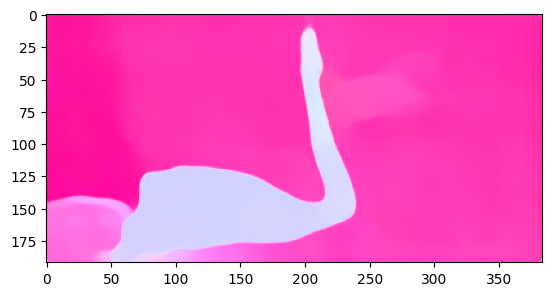

In [15]:
show_flow('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/swan/optical_flow/direct/inference/run.epoch-0-flow-field/000024.flo')

As we can see, the background has darker color, implying that it holds huge deplacement.

Therefore, it's necessary to filter the background flow by thresholding

In [ ]:
# Chia trường hợp ra 1. vat nhanh hon background 2. vat cham hon 3. ko ap dung thres (khi background ko move)
# background nhanh -> dam -> 0, vat 1
# vat nhanh -> dam -> 0 vat, background 0

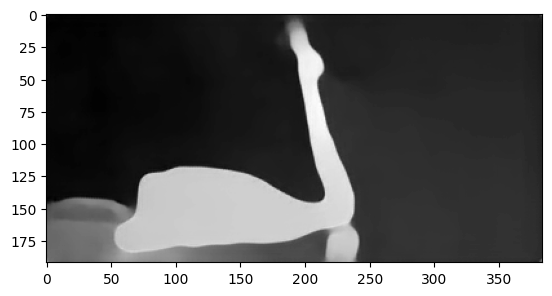

In [39]:
from skimage.color import rgb2gray
from skimage.filters import threshold_li

flow_test = read_flow('/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets/swan/optical_flow/direct/inference/run.epoch-0-flow-field/000025.flo')
img_test = flow_to_image(flow_test)

img_gray = (rgb2gray(img_test)*255).astype(int)
plt.figure()
plt.imshow(img_gray, cmap=plt.cm.gray)
plt.show()

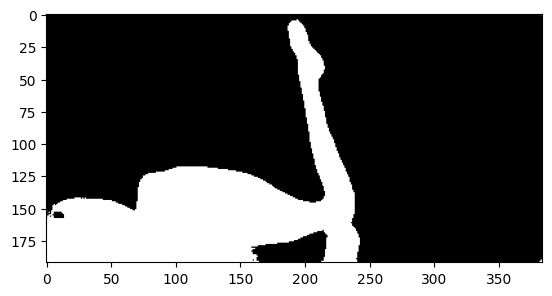

In [40]:
threshold = threshold_li(img_gray)
img_thres = img_gray.copy()
img_thres[img_gray>threshold] = 1
img_thres[img_gray<=threshold] = 0
plt.imshow(img_thres, cmap=plt.cm.gray)

In [16]:
# Return flow
def get_flow(flow, eliminate_background_flow = True, object_flow = 1):
    '''
    flow: flow from read_flow
    eliminate_background_flow: allow to isolate the object flow in case moving camera
    object_flow: 1 - if object moves slower than background flow and vice versa
    '''

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    # Thresholding
    if eliminate_background_flow:
      img_flow = flow_to_image(flow)
      img_flow = (rgb2gray(img_flow)*255).astype(int)
      threshold = threshold_li(img_flow)
      img_thres = img_flow.copy()

      img_thres[img_flow>threshold] = 1 if object_flow else 0
      img_thres[img_flow<=threshold] = 0 if object_flow else 1

      u = u * img_thres
      v = v * img_thres

    return np.dstack((u,v))

## Purpose of the project

Implement the methodology described in one of the two articles and apply it in the context of **visual tracking of video objects** within image sequences. Specifically, the targeted application consists in estimating for the whole sequence the location of a manually defined region of interest in the first image, called **reference image**. Development will be done in `python` programming language and can use functions from librairies such as `openCV`, `scikit-image`, `scikit-learn`, `keras`, `pytorch`...

In [18]:
import numpy as np
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

## Data

You have 6 video sequences containing a **variable number of images** (from 26 to 196). You can evaluate your method with these videos and compare it with the approaches implemented by the other groups as well as the baseline provided below. The **training sequences** (`bag`, `bear`, `book`, `camel`, `rhino`, `swan`) are available on Moodle.

A binary mask is associated to each image to locate the object of interest (foreground object). Only one object of interest is targeted ! Except for the reference image, these **groundtruth masks** can only be used for the evaluation of the implemented method.

**Test sequences** will be provided at the end of the project.

In [19]:
import os

In [20]:
# Path to your datasets
path = '/content/drive/MyDrive/Project_CV/flownet2-pytorch/datasets'

In [21]:
name = 'swan'
img_path = os.path.join(path, name, 'img_crop', name) # name of the sequence : bag, bear, book, camel, rhino, swan
mask_path = os.path.join(path, name, 'mask_crop', name)
im_begin, im_end = 1, 26 # reference image (1) and last image (varies depending on the sequence)

Let us visualize some images with associated groundtruth masks.

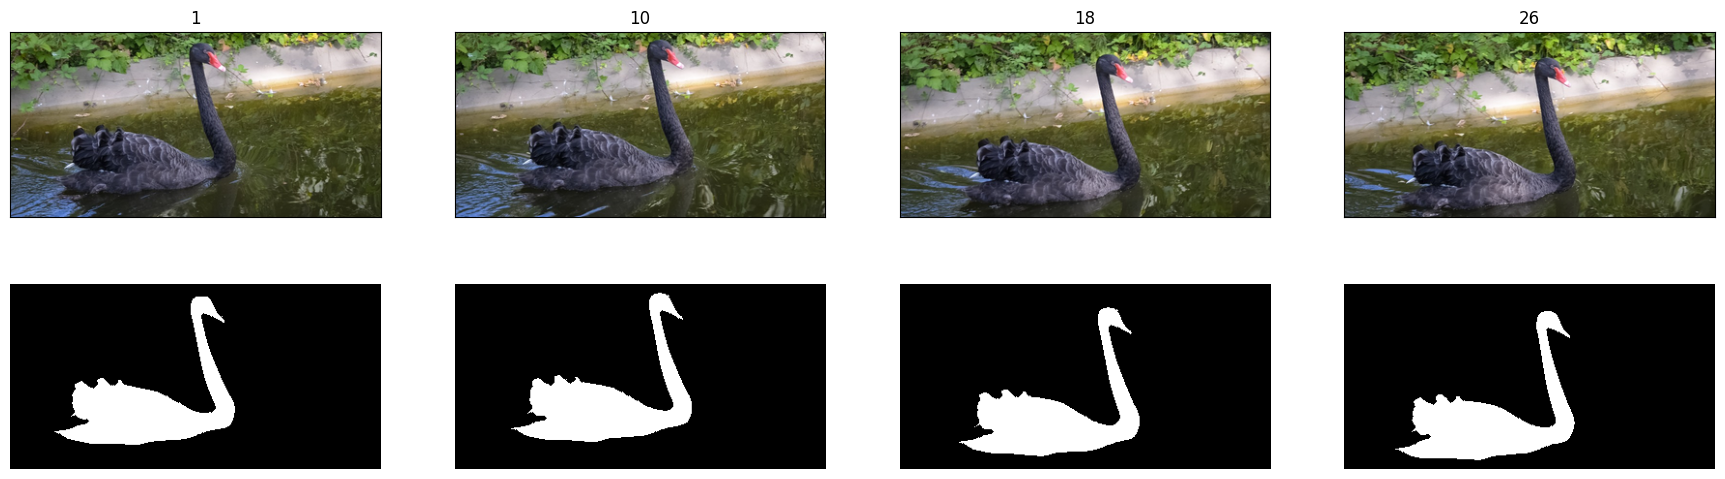

In [22]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = io.imread(img_path+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(mask_path+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The `dice_assessment()`, `db_eval_boundary()` and `centroid_assessment()` functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object.

`dice_assessment()` evaluates the overlap between the two masks while `db_eval_boundary()` quantifies the quality of the estimated contours. Each function returns a score between 0% (poor quality) and 100% (perfect quality).

`centroid_assessment()` comptes the *Euclidean* distance between groundtruth and estimated centroids.

In [24]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [25]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [26]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

The **baseline** code below shows, as an indication, the implementation of a possible methodology (among others) to meet the project requirements.

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called **reference image**. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an `openCV` implementation of the **Farnebäck's optical flow estimator** (G. Farnebäck, [Two-frame motion estimation based on polynomial expansion](https://link.springer.com/content/pdf/10.1007/3-540-45103-x_50.pdf), Image Analysis, pp. 363–370, 2003) is used.


In [27]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the `propagate_mask() `function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [28]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [29]:
img_begin = io.imread(img_path+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread(mask_path+'-%0*d.png'%(3,im_begin))
flow_path = os.path.join(path, name, 'optical_flow', 'direct', 'inference', 'run.epoch-0-flow-field')
idx_flow = sorted(os.listdir(flow_path))

try:
  os.mkdir(os.path.join(path, name, 'tracking_results'))
except:
  pass

save_path = os.path.join(path, name, 'tracking_results')
dices, fmeasures, centroid_dist, visu = [], [], [], []

for im in range(im_begin+1,im_end+1):
    if threshold < 7:
      threshold += 1
    else:
      threshold = 20
    print(im) # debug
    img_current = io.imread(img_path+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(mask_path+'-%0*d.png'%(3,im))

    flow = read_flow(os.path.join(flow_path, idx_flow[im-2]))
    flow = get_flow(flow)

    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(os.path.join(save_path, name) + '-prop-%0*d.png'%(3,im), img_as_ubyte(propagation))
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    io.imsave(os.path.join(save_path, name) + '-bound-%0*d.png'%(3,im), img_as_ubyte(visu[-1]))
    dices.append(dice_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


## Results visualization

Once your method is implemented, you will be able to display the evolution of dice, F-measure scores and distance between centroids along the video sequences...

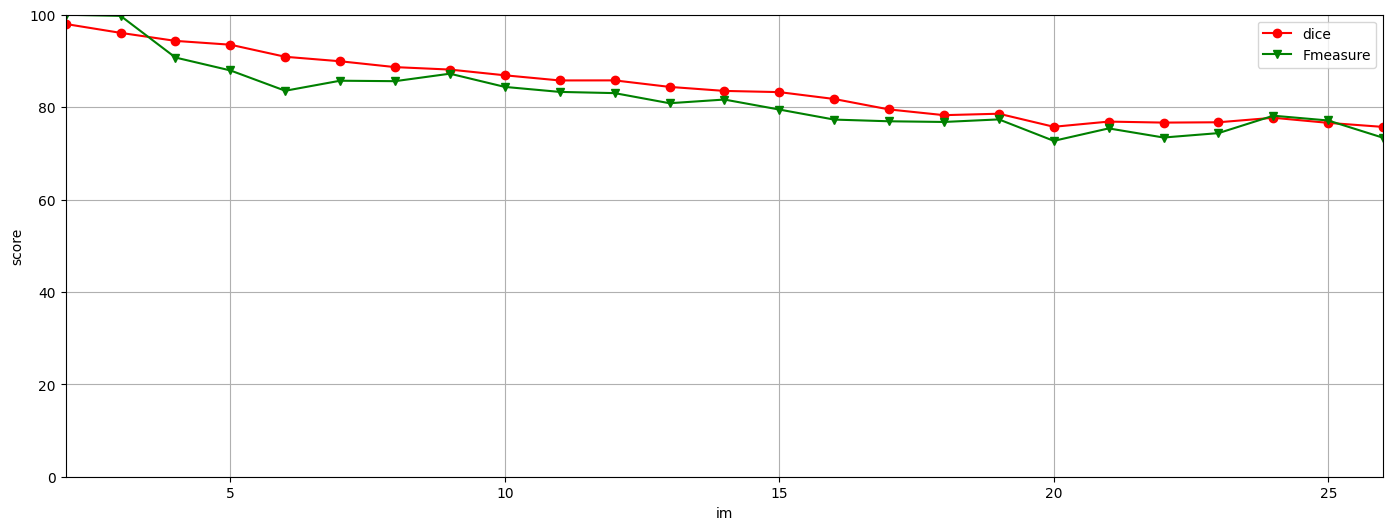

In [30]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig('eval.png')
plt.show()

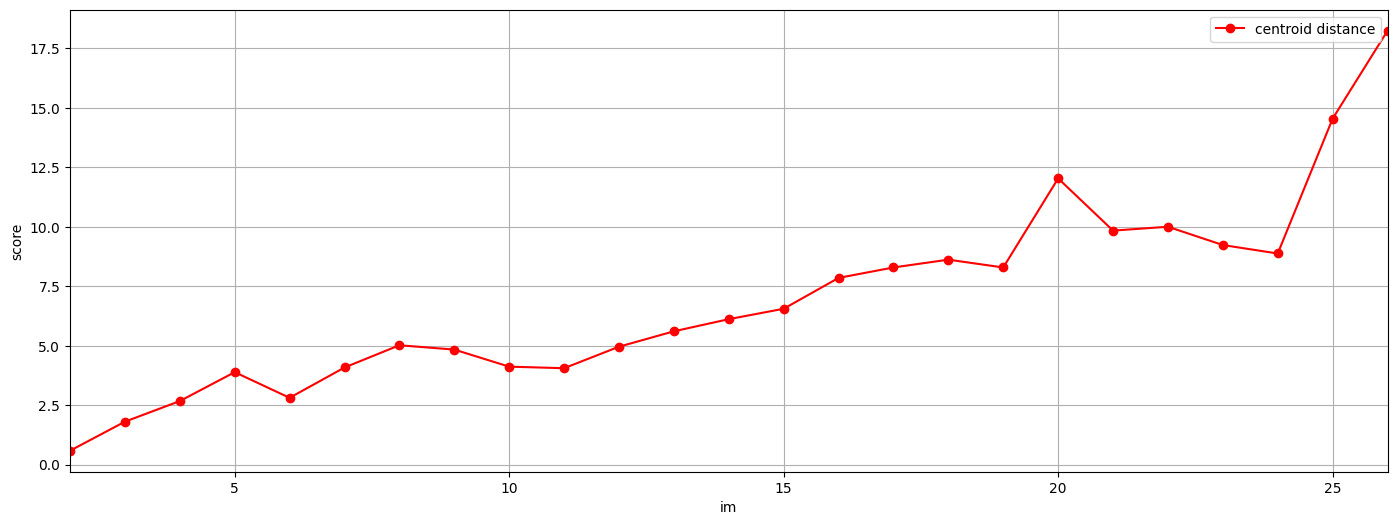

In [31]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
plt.savefig('eval-centroid.png')
plt.show()

... and view the obtained **tracking results** (ground truth in green, estimated contours in red) !

<Figure size 640x480 with 0 Axes>

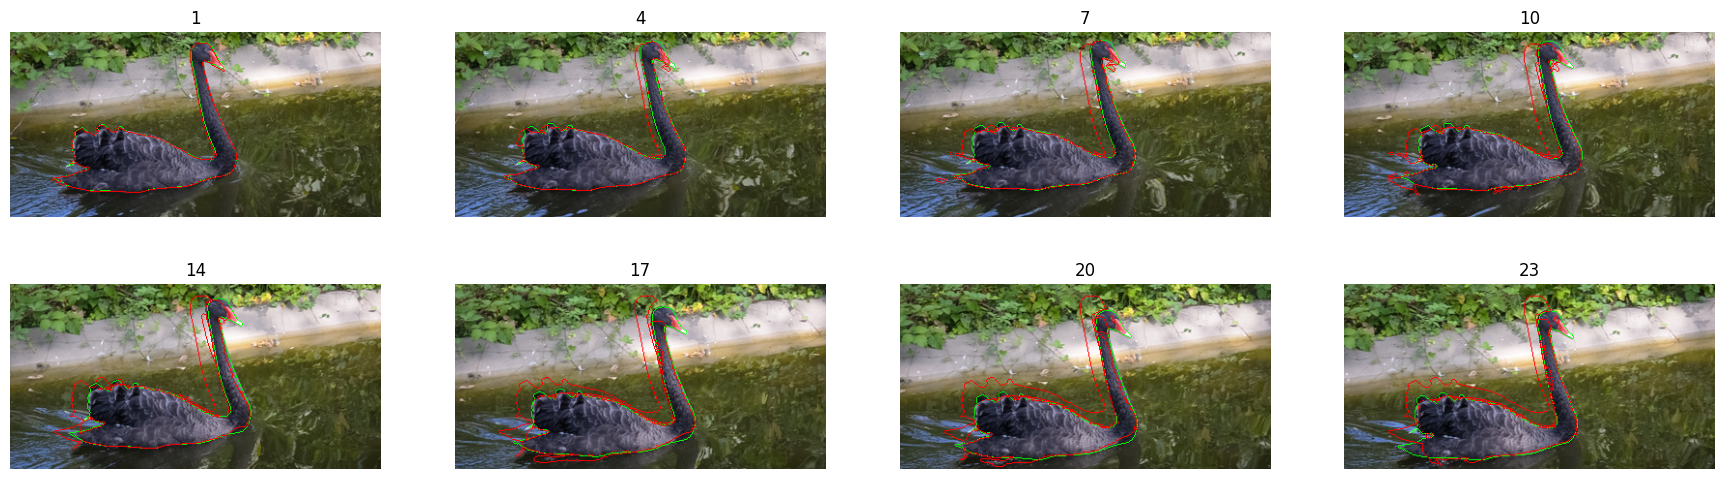

In [32]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

**Sequential integration**

In [34]:
from scipy.interpolate import interp2d

def concatenation(unary_flow, to_ref_flow):
    flow = np.zeros((unary_flow.shape[0],unary_flow.shape[1],2), dtype=float)
    x0 = np.arange(0, unary_flow.shape[0])
    y0 = np.arange(0, unary_flow.shape[1])
    xx, yy = np.meshgrid(x0, y0)
    z = to_ref_flow[xx,yy,1]
    fx = interp2d(x0,y0,z,kind='cubic')
    z = to_ref_flow[xx,yy,0]
    fy = interp2d(x0,y0,z,kind='cubic')
    for x in range(unary_flow.shape[0]):
        for y in range(unary_flow.shape[1]):
            flow_x = fx(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow_y = fy(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow[x,y,1] = unary_flow[x,y,1] + flow_x
            flow[x,y,0] = unary_flow[x,y,0] + flow_y
    return flow

In [35]:
try:
  os.mkdir(os.path.join(path, name, 'tracking_results_sequential'))
except:
  pass

flow_path = os.path.join(path, name, 'optical_flow', 'sequential', 'inference', 'run.epoch-0-flow-field')
idx_flow = sorted(os.listdir(flow_path))
save_path = os.path.join(path, name, 'tracking_results_sequential')
dices, fmeasures, centroid_dist, visu = [], [], [], []

img_begin = io.imread(img_path+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread(mask_path+'-%0*d.png'%(3,im_begin))

for im in range(im_begin+1,im_end+1):
    print(im) # debug
    img_current = io.imread(img_path+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(mask_path+'-%0*d.png'%(3,im))

    if im == im_begin+1:
      seq_flow = read_flow(os.path.join(flow_path, idx_flow[im-2]))
      seq_flow = get_flow(seq_flow)
    else:
      u_flow = read_flow(os.path.join(flow_path, idx_flow[im-2]))
      u_flow = get_flow(seq_flow)
      seq_flow = concatenation(u_flow, seq_flow)

    propagation = propagate_mask(seq_flow, img_current, mask_begin)
    io.imsave(os.path.join(save_path, name) + '-prop-%0*d.png'%(3,im), img_as_ubyte(propagation))
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    io.imsave(os.path.join(save_path, name) + '-bound-%0*d.png'%(3,im), img_as_ubyte(visu[-1]))
    dices.append(dice_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

2
3


<ipython-input-34-a1376e4c1894>:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fx = interp2d(x0,y0,z,kind='cubic')
<ipython-input-34-a1376e4c1894>:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, 

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


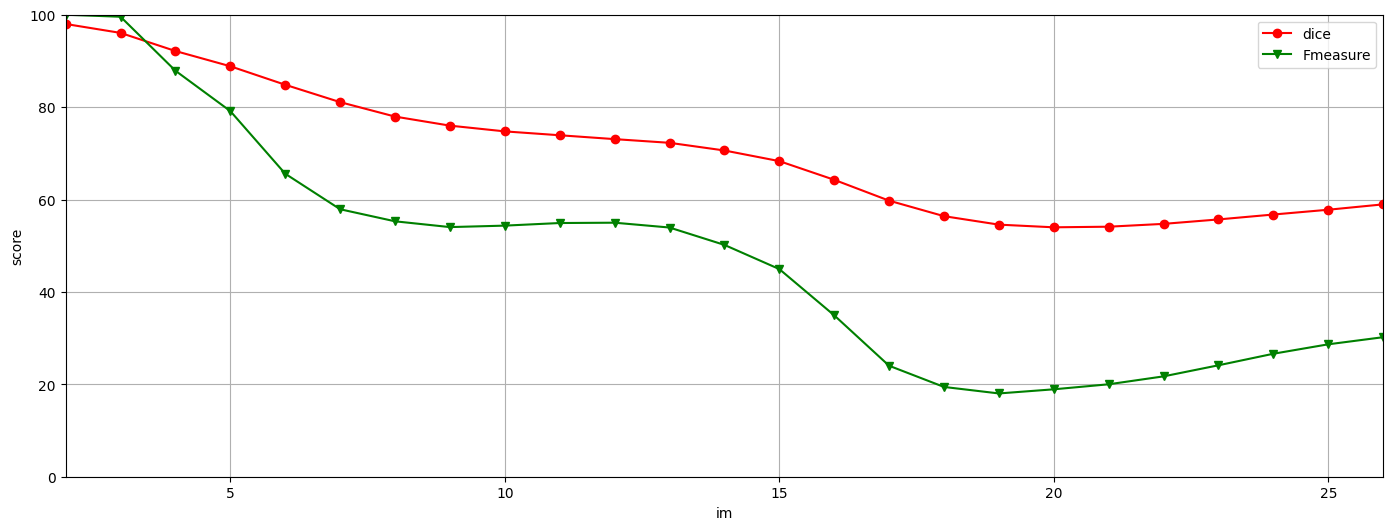

In [36]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig('eval.png')
plt.show()

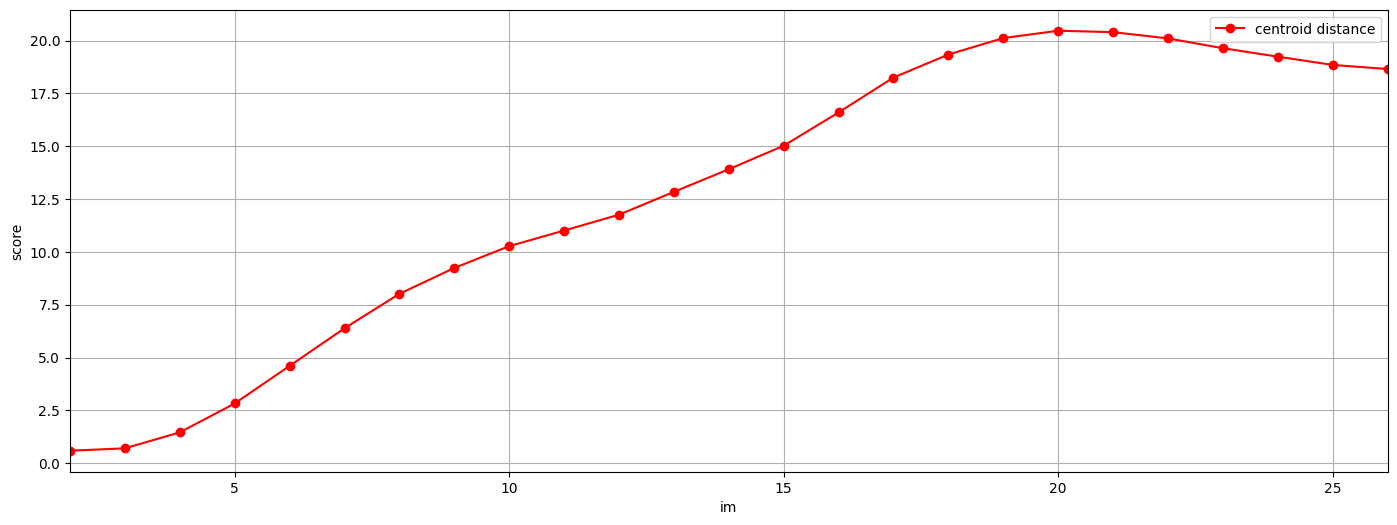

In [37]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
plt.savefig('eval-centroid.png')
plt.show()

<Figure size 640x480 with 0 Axes>

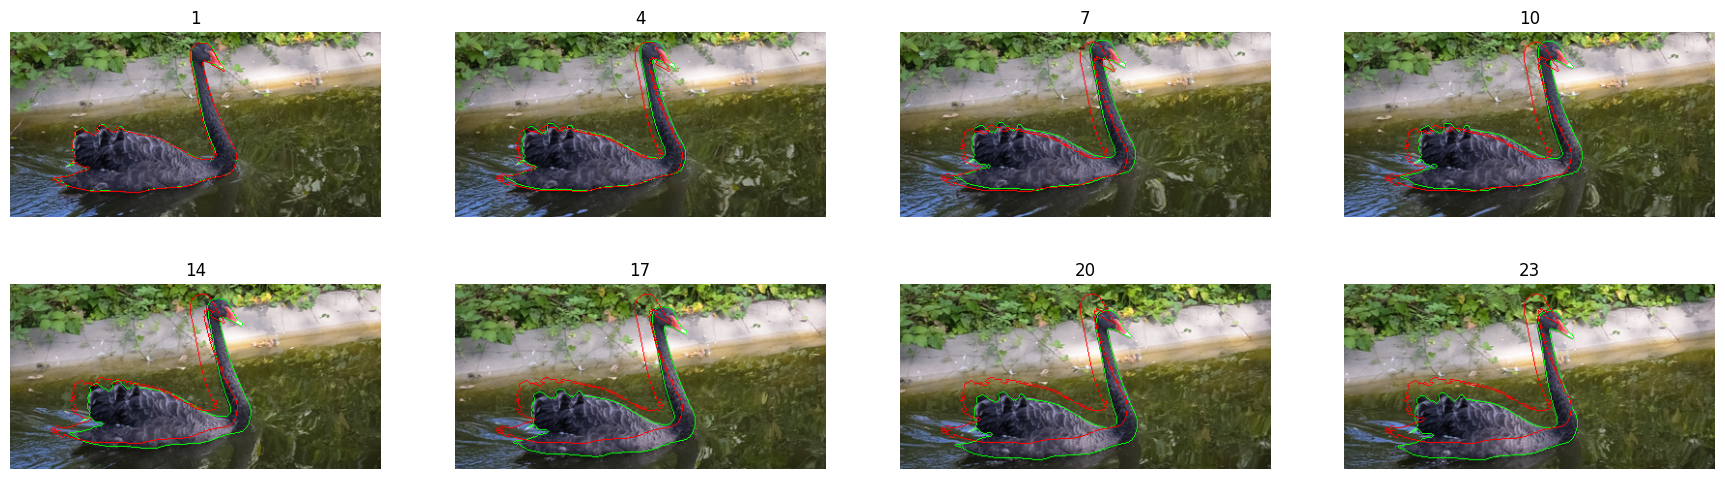

In [38]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()